# anomaly maps 

In [38]:
import datetime as dtmod
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os.path
import re
import netCDF4 as nc
import sys
import scipy.stats
import pandas as pd
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib
import matplotlib.colors as mcolors
import urllib.request
import requests
from bs4 import BeautifulSoup




def anom_map_plot(clim_mean_wrsi_xr, ens_mean_wrsi_xr, poi_stamp, forecast_stamp, clim_start_year, clim_end_year, poi_str, loc_stamp):
    """
    Plot climatology: clim_mean_wrsi_xr.T
    Plot forecast: ens_mean_wrsi_xr.T
    Plot anomaly: percent_anom
    
    """
    # Extract lons and lats for plotting axies
    lons = clim_mean_wrsi_xr['longitude'].values
    lats = clim_mean_wrsi_xr['latitude'].values
    # Calculate max values to standardised colorbars on both plots
    vmax = np.nanmax([clim_mean_wrsi_xr.to_array(), ens_mean_wrsi_xr.to_array()])
    # Calculate percent anomaly    
    percent_anom = (ens_mean_wrsi_xr / clim_mean_wrsi_xr) * 100
    # Save to netCDF - perc_anom
    percent_anom_xr = xr.DataArray(percent_anom.to_array()[0], coords = {'latitude':lons,'latitude': lats}, dims = ['longitude','latitude'])
    file_path='/home/data_folder/20220825/'
    percent_anom_xr.to_netcdf(file_path+"test_percent_anom_"+poi_stamp+"_"+forecast_stamp+"_"+loc_stamp+".nc")
    # Colormap setup - make 'bad' values grey
    BrBG_cust = matplotlib.cm.get_cmap("BrBG")
    BrBG_cust.set_bad(color = "silver")
    RdBu_cust = matplotlib.cm.get_cmap("RdBu")
    RdBu_cust.set_bad(color = "silver")
    # Build plot
    fig = plt.figure(figsize = (32,10))
    # Plot climatology
    clim_plt = fig.add_subplot(131, projection = ccrs.PlateCarree())
    clim_plt.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)])
    clim_plt.pcolormesh(lons, lats, clim_mean_wrsi_xr.to_array()[0].T, vmin = 0, vmax = vmax, cmap = BrBG_cust)
    clim_gl = clim_plt.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, linewidth = 0.7, color = "black", alpha = 1, linestyle = "--")
    clim_gl.xlabels_top = False
    clim_gl.ylabels_right = False
    clim_gl.xlabel_style = {'size': 18}
    clim_gl.ylabel_style = {'size': 18}
    clim_gl.xformatter = LONGITUDE_FORMATTER
    clim_gl.yformatter = LATITUDE_FORMATTER
    clim_plt.set_title('SM (beta) climatology\n' + poi_str + ' ' + str(clim_start_year) + '-' + str(clim_end_year), fontsize = 20)
    clim_cb = plt.pcolormesh(lons, lats, clim_mean_wrsi_xr.to_array()[0].T, vmin = 0, vmax = vmax, cmap = BrBG_cust)
    clim_cb = plt.colorbar(clim_cb)
    clim_cb.ax.tick_params(labelsize=18)
    clim_plt.set_aspect("auto", adjustable = None)
    clim_plt.add_feature(cfeature.OCEAN, facecolor = "white", zorder = 1)
    clim_plt.add_feature(cfeature.COASTLINE, linewidth = 2)
    #clim_plt.add_feature(cfeature.BORDERS, linewidth = 2)
    fname='/home/data_folder/shapefiles/ea_ghcf_icpac.shp'
    clim_plt.add_geometries(Reader(fname).geometries(),ccrs.PlateCarree(),facecolor='None', linewidth = 2)
    # Plot forecast
    ens_plt = fig.add_subplot(132, projection = ccrs.PlateCarree())
    ens_plt.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)])
    ens_plt.pcolormesh(lons, lats, ens_mean_wrsi_xr.to_array()[0].T, vmin = 0, vmax = vmax, cmap = BrBG_cust)
    ens_gl = ens_plt.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, linewidth = 0.7, color = "black", alpha = 1, linestyle = "--")
    ens_gl.xlabels_top = False
    ens_gl.ylabels_right = False
    ens_gl.xlabel_style = {'size': 18}
    ens_gl.ylabel_style = {'size': 18}
    ens_gl.xformatter = LONGITUDE_FORMATTER
    ens_gl.yformatter = LATITUDE_FORMATTER
    ens_plt.set_title('SM (beta) forecast for ' + poi_stamp + "\nIssued "+ forecast_stamp, fontsize = 20)
    ens_cb = plt.pcolormesh(lons, lats, ens_mean_wrsi_xr.to_array()[0].T, vmin = 0, vmax = vmax, cmap = BrBG_cust)
    ens_cb = plt.colorbar(ens_cb)
    ens_cb.ax.tick_params(labelsize=18)
    ens_plt.set_aspect("auto", adjustable = None)
    ens_plt.add_feature(cfeature.OCEAN, facecolor = "white", zorder = 1)
    ens_plt.add_feature(cfeature.COASTLINE, linewidth = 2)
    #ens_plt.add_feature(cfeature.BORDERS, linewidth = 2)
    fname='/home/data_folder/shapefiles/ea_ghcf_icpac.shp'
    ens_plt.add_geometries(Reader(fname).geometries(),ccrs.PlateCarree(),facecolor='None', linewidth = 2)
    # Plot anomaly
    anom_plt = fig.add_subplot(133, projection = ccrs.PlateCarree())
    anom_plt.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)])
    anom_plt.pcolormesh(lons, lats, percent_anom.to_array()[0].T, vmin = 50, vmax = 150, cmap = RdBu_cust)
    anom_gl = anom_plt.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, linewidth = 0.7, color = "black", alpha = 1, linestyle = "--")
    anom_gl.xlabels_top = False
    anom_gl.ylabels_right = False
    anom_gl.xlabel_style = {'size': 18}
    anom_gl.ylabel_style = {'size': 18}
    anom_gl.xformatter = LONGITUDE_FORMATTER
    anom_gl.yformatter = LATITUDE_FORMATTER
    anom_plt.set_title('SM (beta) % anomaly for ' + poi_stamp + "\nIssued "+ forecast_stamp, fontsize = 20)
    anom_cb = plt.pcolormesh(lons, lats, percent_anom.to_array()[0].T, vmin = 50, vmax = 150, cmap = RdBu_cust)
    anom_cb = plt.colorbar(anom_cb)
    anom_cb.ax.tick_params(labelsize=18)
    anom_plt.set_aspect("auto", adjustable = None)
    anom_plt.add_feature(cfeature.OCEAN, facecolor = "white", zorder = 1)
    anom_plt.add_feature(cfeature.COASTLINE, linewidth = 2)
    #anom_plt.add_feature(cfeature.BORDERS, linewidth = 2)
    fname='/home/data_folder/shapefiles/ea_ghcf_icpac.shp'
    anom_plt.add_geometries(Reader(fname).geometries(),ccrs.PlateCarree(),facecolor='None', linewidth = 2)
    # Save and show
    plt.savefig(file_path+"test_map_plot"+poi_stamp+"_"+forecast_stamp+"_"+loc_stamp+".png")
    plt.close()

In [39]:

poi_stamp='OND2022'
forecast_stamp='20220825'
clim_start_year='2005'
clim_end_year='2019'
poi_str= 'OND'
loc_stamp='ea'


clim_mean_wrsi_xr=xr.open_dataset('/home/data_folder/20220825/clim_mean_wrsi_OND2022_20220825_21.838949_51.415695_-11.745695_23.145147.nc')

ens_mean_wrsi_xr=xr.open_dataset('/home/data_folder/20220825/ens_mean_wrsi_OND2022_20220825_21.838949_51.415695_-11.745695_23.145147.nc')

#clim_mean_wrsi_xr=clim_mean_wrsi_xr_data.to_array()
#ens_mean_wrsi_xr=ens_mean_wrsi_xr_data.to_array()

anom_map_plot(clim_mean_wrsi_xr, ens_mean_wrsi_xr, poi_stamp, forecast_stamp, clim_start_year, clim_end_year, poi_str, loc_stamp)

/tmp/ipykernel_41/3642705399.py:44: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("BrBG").copy()
  BrBG_cust.set_bad(color = "silver")
/tmp/ipykernel_41/3642705399.py:46: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdBu").copy()
  RdBu_cust.set_bad(color = "silver")
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top at

/tmp/ipykernel_41/3827182265.py:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("BrBG").copy()
  BrBG_cust.set_bad(color = "silver")
/tmp/ipykernel_41/3827182265.py:20: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdBu").copy()
  RdBu_cust.set_bad(color = "silver")
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top at

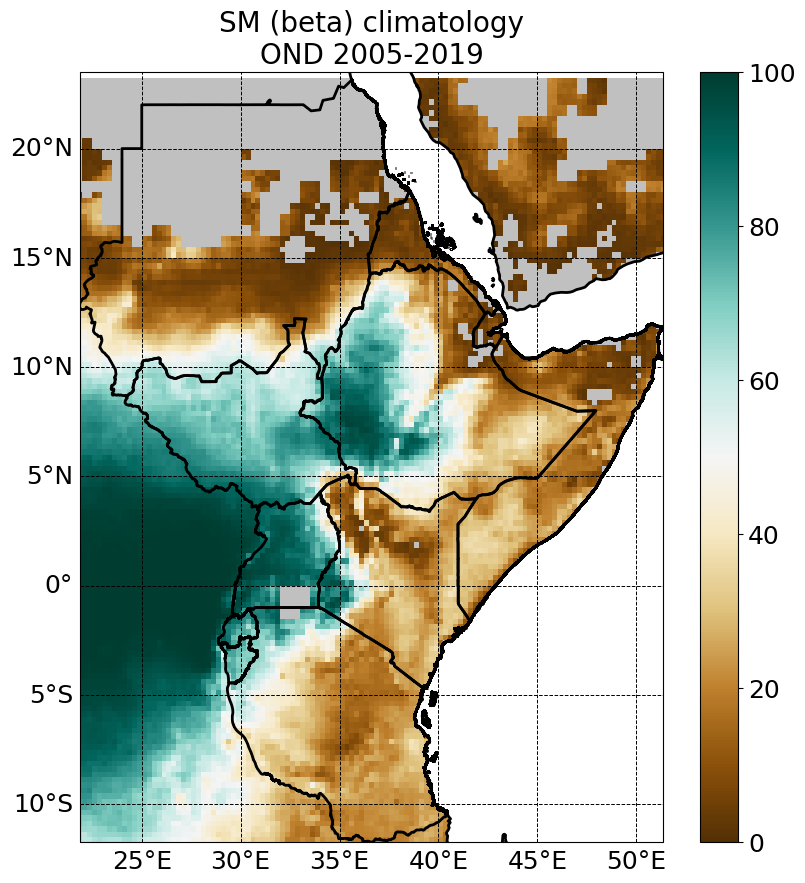

In [37]:
from cartopy.io.shapereader import Reader

clim_mean_wrsi_xr=xr.open_dataset('/home/data_folder/20220825/clim_mean_wrsi_OND2022_20220825_21.838949_51.415695_-11.745695_23.145147.nc')

ens_mean_wrsi_xr=xr.open_dataset('/home/data_folder/20220825/ens_mean_wrsi_OND2022_20220825_21.838949_51.415695_-11.745695_23.145147.nc')


lons = clim_mean_wrsi_xr['longitude'].values
lats = clim_mean_wrsi_xr['latitude'].values
# Calculate max values to standardised colorbars on both plots
vmax = np.nanmax([clim_mean_wrsi_xr.to_array(), ens_mean_wrsi_xr.to_array()])
# Calculate percent anomaly    
percent_anom = (ens_mean_wrsi_xr / clim_mean_wrsi_xr) * 100
# Save to netCDF - perc_anom
percent_anom_xr = xr.DataArray(percent_anom.to_array()[0], coords = {'latitude':lons,'latitude': lats}, dims = ['longitude','latitude'])
#percent_anom_xr.to_netcdf(file_path+"/outputs/percent_anom_"+poi_stamp+"_"+forecast_stamp+"_"+loc_stamp+".nc")
BrBG_cust = matplotlib.cm.get_cmap("BrBG")
BrBG_cust.set_bad(color = "silver")
RdBu_cust = matplotlib.cm.get_cmap("RdBu")
RdBu_cust.set_bad(color = "silver")
# Build plot
fig = plt.figure(figsize = (32,10))
# Plot climatology
clim_plt = fig.add_subplot(131, projection = ccrs.PlateCarree())
clim_plt.set_extent([np.min(lons), np.max(lons), np.min(lats)-0.1, np.max(lats)])
data=clim_mean_wrsi_xr.to_array()[0].T
clim_plt.pcolormesh(lons, lats, data, vmin = 0, vmax = vmax, cmap = BrBG_cust)
clim_gl = clim_plt.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, linewidth = 0.7, color = "black", alpha = 1, linestyle = "--")
clim_gl.xlabels_top = False
clim_gl.ylabels_right = False
clim_gl.xlabel_style = {'size': 18}
clim_gl.ylabel_style = {'size': 18}
clim_gl.xformatter = LONGITUDE_FORMATTER
clim_gl.yformatter = LATITUDE_FORMATTER
clim_plt.set_title('SM (beta) climatology\n' + poi_str + ' ' + str(clim_start_year) + '-' + str(clim_end_year), fontsize = 20)
clim_cb = plt.pcolormesh(lons, lats, clim_mean_wrsi_xr.to_array()[0].T, vmin = 0, vmax = vmax, cmap = BrBG_cust)
clim_cb = plt.colorbar(clim_cb)
clim_cb.ax.tick_params(labelsize=18)
clim_plt.set_aspect("auto", adjustable = None)
clim_plt.add_feature(cfeature.OCEAN, facecolor = "white", zorder = 1)
clim_plt.add_feature(cfeature.COASTLINE, linewidth = 2)
#clim_plt.add_feature(cfeature.BORDERS, linewidth = 2)
fname='/home/data_folder/shapefiles/ea_ghcf_icpac.shp'
clim_plt.add_geometries(Reader(fname).geometries(),ccrs.PlateCarree(),facecolor='None', linewidth = 2)

plt.show()

In [16]:
aa=percent_anom.to_array()[0]
aa.shape

(119, 140)

In [12]:
tdb=xr.open_dataset('/home/data_folder/20220825/percent_anom_OND2022_20220825_21.838949_51.415695_-11.745695_23.145147.nc')
tdb

<xarray.Dataset>
Dimensions:                        (longitude: 119, latitude: 140)
Coordinates:
  * longitude                      (longitude) float32 21.88 22.12 ... 51.38
  * latitude                       (latitude) float32 -11.62 -11.38 ... 23.12
Data variables:
    __xarray_dataarray_variable__  (longitude, latitude) float64 ...

In [32]:
np.min(lats)-0.1

-11.725

## prob_map_plot

In [57]:

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict) 


def prob_map_plot(clim_mean_wrsi_xr, clim_sd_wrsi_xr, ens_mean_wrsi_xr, ens_sd_wrsi_xr, poi_stamp, forecast_stamp, loc_stamp):
    # Extract lons and lats for plotting axies
    file_path='/home/data_folder/20220825/'
    lons = clim_mean_wrsi_xr['longitude'].values
    lats = clim_mean_wrsi_xr['latitude'].values
    lower_thresh = 0.33
    # Calculate probability of lower tercile soil moisture
    a = scipy.stats.norm(clim_mean_wrsi_xr.to_array(), clim_sd_wrsi_xr.to_array()).ppf(0.33)
    b_lower = scipy.stats.norm(ens_mean_wrsi_xr.to_array(), ens_sd_wrsi_xr.to_array()).cdf(a)
    # Save to netCDF - prob_lower_terc
    b_lower_xr = xr.DataArray(b_lower[0], coords = {'latitude':lons,'latitude': lats}, dims = ['longitude','latitude'])
    b_lower_xr.to_netcdf(file_path+"test_prob_lower_tercile_"+poi_stamp+"_"+forecast_stamp+"_"+loc_stamp+".nc")
   # Colormap setup - make 'bad' values grey
    c = mcolors.ColorConverter().to_rgb
    rvb = make_colormap([c('green'), c('palegreen'), lower_thresh - 0.05, c('white'), c('white'), lower_thresh + 0.05, c('yellow'), c('brown')])
    rvb_cust = matplotlib.cm.get_cmap(rvb)
    rvb_cust.set_bad(color = "silver")
    # Extract lons and lats for plotting axies
    lons = clim_mean_wrsi_xr['longitude'].values
    lats = clim_mean_wrsi_xr['latitude'].values    
    # Build plot
    fig = plt.figure(figsize = (10,10))
    # Plot climatology
    prob_plt = fig.add_subplot(111, projection = ccrs.PlateCarree())
    prob_plt.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)])
    prob_plt.pcolormesh(lons, lats, b_lower[0].T, vmin = 0, vmax = 1, cmap = rvb_cust)
    prob_gl = prob_plt.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, linewidth = 0.7, color = "black", alpha = 1, linestyle = "--")
    prob_gl.xlabels_top = False
    prob_gl.ylabels_right = False
    prob_gl.xlabel_style = {'size': 18}
    prob_gl.ylabel_style = {'size': 18}
    prob_gl.xformatter = LONGITUDE_FORMATTER
    prob_gl.yformatter = LATITUDE_FORMATTER
    prob_plt.set_title('Probability of lower tercile SM\n' + poi_stamp + " Issued "+ forecast_stamp, fontsize = 20)
    prob_cb = plt.pcolormesh(lons, lats, b_lower[0].T, vmin = 0, vmax = 1, cmap = rvb_cust)
    prob_cb = plt.colorbar(prob_cb)
    prob_cb.ax.tick_params(labelsize=18)
    prob_plt.set_aspect("auto", adjustable = None)
    prob_plt.add_feature(cfeature.OCEAN, facecolor = "white", zorder = 1)
    prob_plt.add_feature(cfeature.COASTLINE, linewidth = 2)
    #prob_plt.add_feature(cfeature.BORDERS, linewidth = 2)
    fname='/home/data_folder/shapefiles/ea_ghcf_icpac.shp'
    prob_plt.add_geometries(Reader(fname).geometries(),ccrs.PlateCarree(),facecolor='None', linewidth = 2)
    # Save and show
    plt.savefig(file_path+"test_prob_map_plot"+poi_stamp+"_"+forecast_stamp+"_"+loc_stamp+".png")
    plt.close()

In [58]:

clim_mean_wrsi_xr=xr.open_dataset('/home/data_folder/20220825/clim_mean_wrsi_OND2022_20220825_21.838949_51.415695_-11.745695_23.145147.nc')

ens_mean_wrsi_xr=xr.open_dataset('/home/data_folder/20220825/ens_mean_wrsi_OND2022_20220825_21.838949_51.415695_-11.745695_23.145147.nc')

clim_sd_wrsi_xr=xr.open_dataset('/home/data_folder/20220825/clim_sd_wrsi_OND2022_20220825_21.838949_51.415695_-11.745695_23.145147.nc')

ens_sd_wrsi_xr=xr.open_dataset('/home/data_folder/20220825/ens_sd_wrsi_OND2022_20220825_21.838949_51.415695_-11.745695_23.145147.nc')


a = scipy.stats.norm(clim_mean_wrsi_xr.to_array(), clim_sd_wrsi_xr.to_array()).ppf(0.33)
b_lower = scipy.stats.norm(ens_mean_wrsi_xr.to_array(), ens_sd_wrsi_xr.to_array()).cdf(a)

poi_stamp='OND2022'
forecast_stamp='20220825'
loc_stamp='ea'

prob_map_plot(clim_mean_wrsi_xr, clim_sd_wrsi_xr, ens_mean_wrsi_xr, ens_sd_wrsi_xr, poi_stamp, forecast_stamp, loc_stamp)

#b_lower[0].shape


/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2168: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/root/miniconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is de